**Welcome to this Notebook!**

UCLouvain - EPL - made by Justin Weeamels & Baptiste Sambon - 2023

*In this notebook, we will discover how the inter-cell-interference (ICI) is handled and generated.*

*As a first step, let's import some useful packages.* **As said in the README, run this file twice!**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys

from scipy.spatial import Voronoi, voronoi_plot_2d
from utils import *
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib as mpl

*In this simulation, Base Stations (BS) are randomly placed in a given area. The BS associeated to a User Equipment (UE) is the one closest to the UE. To determine the shape of the cell, the use of the Voronoi diagram is required. The Voronoi diagram is a partition of a plane into regions close to each of a given set of objects. In our case, the objects are the BS. The Voronoi diagram is computed using the scipy package. Let's illustrate how this works with a toy-example.*

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


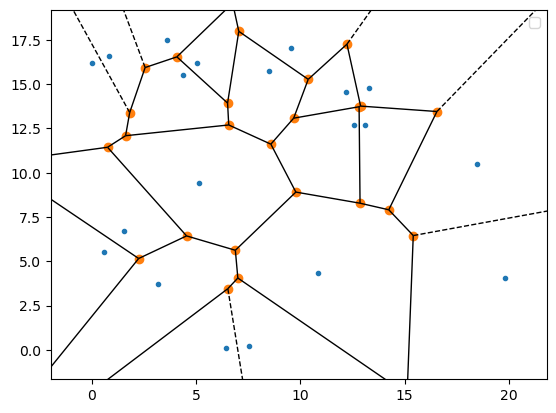

In [2]:
# Dimension of the domain in which to generate the points. 
dim_x = 20 
dim_y = 20 

#Generation of the random points representing the BS points. 
npoints = 20
points = np.random.uniform(0, 20, (npoints, 2))

# Calculation of the Voronoi cells, based on the minimization of the distance to a BS. 
vor = Voronoi(points)

# Show the results of the minimization
fig = voronoi_plot_2d(vor)
plt.legend()
plt.show()


*One can therefore observe that the several cells are generated based on the minimization of the distance of a given point to a BS.*

*Let's now apply it to a real case, with a user located in position [0;0]. The colors used in the following simulation represent the power level received at the user location from the corresponding BS.*

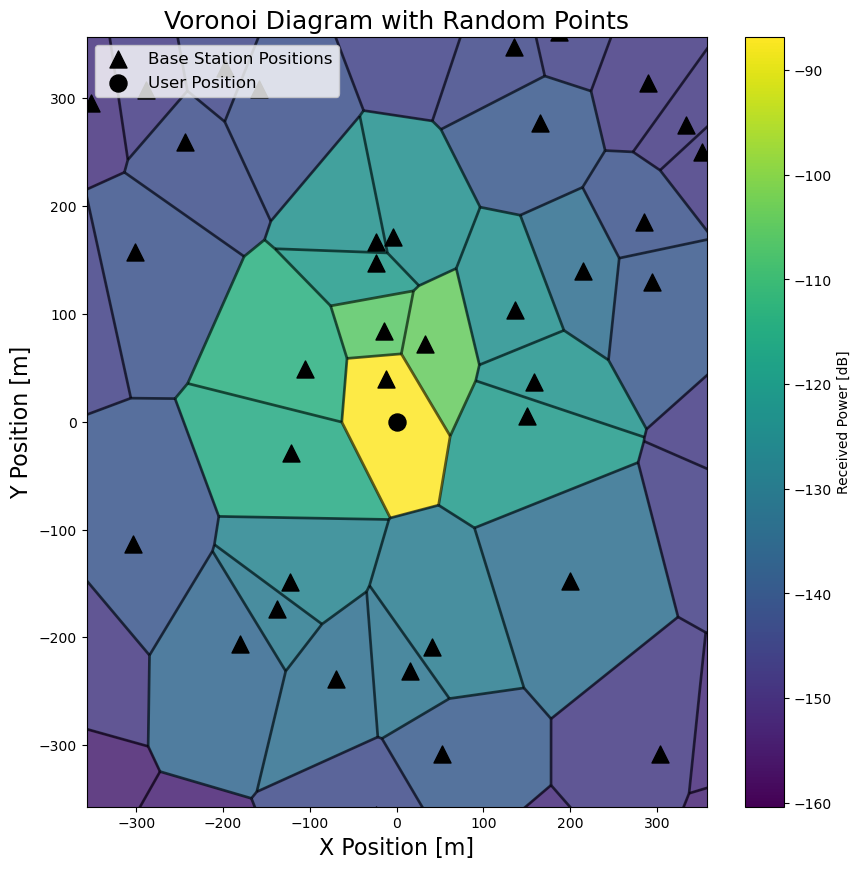

In [4]:
#Fix the seed for the simulation
np.random.seed(18)

# Set parameters
dim = 500       # [m]
npoints = 64    # Number of base stations

# Set user position
user_position = np.array([0, 0])

# Generate random points/random locations for the BS's.
points = np.random.uniform(-dim, dim, (npoints, 2))

# Create Voronoi diagram
vor = Voronoi(points)

# Plot Voronoi diagram with customizations
fig, ax = plt.subplots(figsize=(10, 10))  
voronoi_plot_2d(vor, show_vertices=False, show_points=False, line_colors='k', line_width=2, line_alpha=0.6, ax=ax)

# Calculte the received power from the BS's to the user. 
powers = received_power(points, alpha=6)

# Determine min and max power for colormap normalization
minima = min(10*np.log10(powers))
maxima = max(10*np.log10(powers))

# Normalize chosen colormap
norm = mpl.colors.Normalize(vmin=minima, vmax=maxima, clip=True)
mapper = cm.ScalarMappable(norm=norm, cmap=cm.viridis)

# Determine color base on the power received from the BS. 
for r in range(len(vor.point_region)):
    region_index = vor.point_region[r]
    region = vor.regions[region_index]
    if region_index != -1 and -1 not in region and len(region) > 2:
        polygon = [vor.vertices[i] for i in region]
        plt.fill(*zip(*polygon), color=mapper.to_rgba(10*np.log10(powers[r])), alpha=0.85)

# Plot points
plt.scatter(points[:, 0], points[:, 1], c='black', marker='^',  label='Base Station Positions', s=150)
plt.scatter(user_position[0], user_position[1], c='black', marker='o', label='User Position', s=150)

# Set plot limits and labels
plt.xlim(-dim/1.4, dim/1.4)
plt.ylim(-dim/1.4, dim/1.4)
plt.xlabel('X Position [m]', fontsize=16)
plt.ylabel('Y Position [m]', fontsize=16)
plt.title('Voronoi Diagram with Random Points', fontsize=18)

# Add colorbar
#sm = plt.cm.ScalarMappable(cmap=cm.OrRd, norm=norm)
sm = plt.cm.ScalarMappable(cmap=cm.viridis, norm=norm)
sm.set_array([])
plt.colorbar(sm, label='Received Power [dB]')

# Add legend
plt.legend(loc='upper left', fontsize=12)

# Show the plot
plt.show()


*We can now perform several simulations with random geometries and calculate sevral metrics about the useful and interference powers. The interference power is the sum of the power received from all the other BS than the one associated to the UE. The useful power is the power received from the BS associated to the UE (the closest one to the UE).*

In [5]:
# Set parameters
niters = 3000                               # Number of iterations
ratio_power = np.zeros(niters)              # Ratio between useful power and interefence power
max_powers = np.zeros(niters)               # Maximum received power
inter_powers = np.zeros(niters)             # Interference power
min_distances = np.zeros(niters)            # Minimum distance between user and BS
second_min_distances = np.zeros(niters)     # Second minimum distance between user and BS

for i in range(niters) : 

    #Dimension of the domain
    dim = 1*500
    # Number of BS considered
    npoints = 64

    # Set user position
    user_position = np.array([0, 0])

    # Generate random points
    points = np.random.uniform(-dim, dim, (npoints, 2))

    # Compute distances 
    distances = np.linalg.norm(points-user_position, axis=1)

    # Compute minimum and second minimum distances
    min_distances[i] = np.min(distances)
    second_min_distances[i] = np.partition(distances, 1)[1]


    # Create Voronoi diagram
    vor = Voronoi(points)

    # Calculte the received power from the BS's to the user.
    powers = received_power(points, alpha=6)

    # Compute the ratio between the maximum power and the sum of the other powers.
    ratio_power[i] = np.max(powers)/(np.sum(powers) - np.max(powers))
    # Compute the maximum power and the sum of the other powers.
    max_powers[i] = np.max(powers)
    inter_powers[i] = np.sum(powers) - np.max(powers)


In [11]:
# Save the resulst obtained for later use

np.save("data/ratio_power_interf.npy" , ratio_power)

*First, we can observe the distrubtion of the ratio between the useful and interference power.*

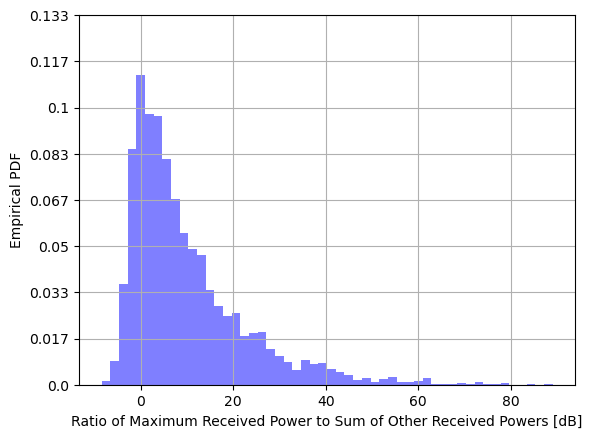

In [12]:
fig = plt.figure()
plt.grid()
hist ,bin_edges = np.histogram(ratio_power, bins='auto', density=False)
plt.hist(10*np.log10(ratio_power), bins='auto', alpha=0.5, color='blue', density=False)
locs, _ = plt.yticks() 
plt.yticks(locs,np.round(locs/len(ratio_power),3))

plt.xlabel('Ratio of Maximum Received Power to Sum of Other Received Powers [dB]')
plt.ylabel('Empirical PDF')
plt.show()

*To analyse the previsous results, we can look at the distribution of the user and the closest BS and then, the distance between the user and the second closest BS. In a second time, we can also look at the difference between those two distances.*

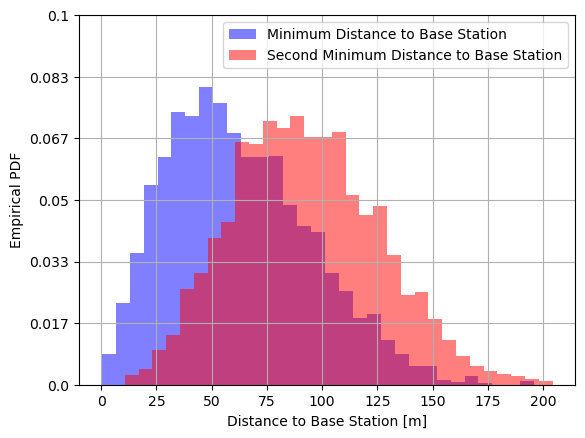

In [13]:
# Plot histogram of distances 
fig = plt.figure()
plt.grid()
plt.hist(min_distances, bins='auto', alpha=0.5, color='blue', density=False, label='Minimum Distance to Base Station')
locs, _ = plt.yticks()
plt.yticks(locs,np.round(locs/len(min_distances),3))
plt.hist(second_min_distances, bins='auto', alpha=0.5, color='red', density=False, label='Second Minimum Distance to Base Station')
locs, _ = plt.yticks()
plt.yticks(locs,np.round(locs/len(second_min_distances),3))
#plt.xlim([0, 10])
plt.xlabel('Distance to Base Station [m]')
plt.ylabel('Empirical PDF')
plt.legend()
plt.show()

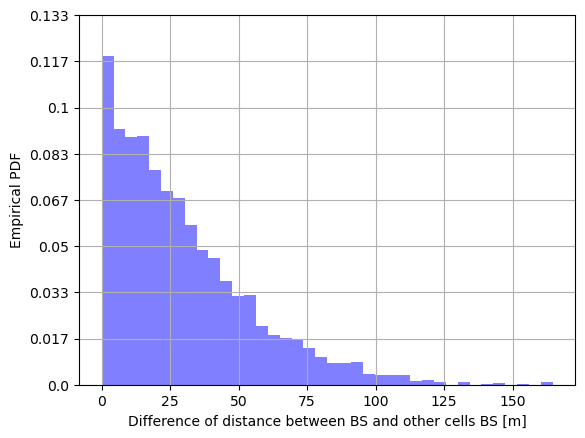

In [14]:
#Plot difference between max and second max
fig = plt.figure()
plt.grid()
plt.hist(second_min_distances - min_distances, bins='auto', alpha=0.5, color='blue', density=False)
locs, _ = plt.yticks()
plt.yticks(locs,np.round(locs/len(max_powers),3))
#plt.xlim([0, 10])
plt.xlabel('Difference of distance between BS and other cells BS [m]')
plt.ylabel('Empirical PDF')
plt.show()

*One particular point of interest is to shwo that we can fit a Gamma distribution function to the ratio of powers found above. This is done by using the scipy package.*

Gamma distribution parameters:  (2.3903097451525017, -7.8917739784396606, 7.694223787955167)


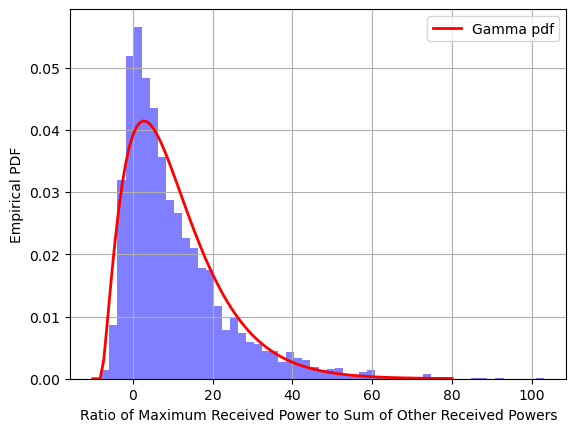

In [6]:
# Fit exponential distribution
import scipy.stats as st

# Fit the Gamma distribution parameters
params = st.gamma.fit(10*np.log10(ratio_power))
print("Gamma distribution parameters: ", params)

# Plot histogram of ratio_powers and gamma distribution
fig = plt.figure()
plt.grid()
plt.hist(10*np.log10(ratio_power), bins='auto', alpha=0.5, color='blue', density=True)
plt.plot(np.linspace(-10, 80, 100), st.gamma.pdf(np.linspace(-10, 80, 100), *params), color='red', lw=2, label='Gamma pdf')
#plt.xlim([0, 10])
plt.xlabel('Ratio of Maximum Received Power to Sum of Other Received Powers')
plt.ylabel('Empirical PDF')
plt.legend()
plt.show()


*Other representations may be useful to interpret the results more easily. For example, we can plot the CDF of the ratio of power or the histogram of the useful power compared to th eone of the interference powers.*

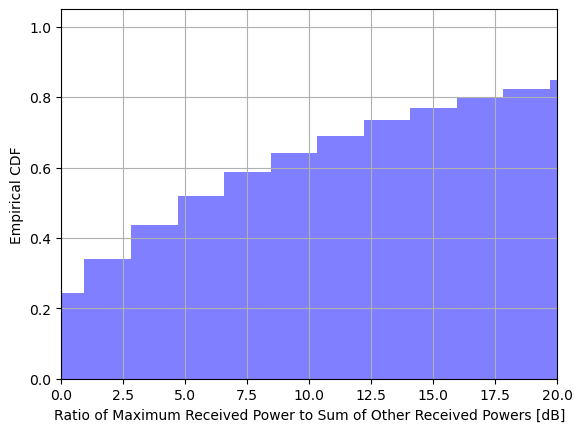

In [17]:
#Plot ccdf of ratio powers
fig = plt.figure()
plt.hist(10*np.log10(ratio_power), bins='auto', alpha=0.5, color='blue', density=True, cumulative=True)
plt.xlim([0, 20])
plt.xlabel('Ratio of Maximum Received Power to Sum of Other Received Powers [dB]')
plt.ylabel('Empirical CDF')
plt.grid()
plt.show()

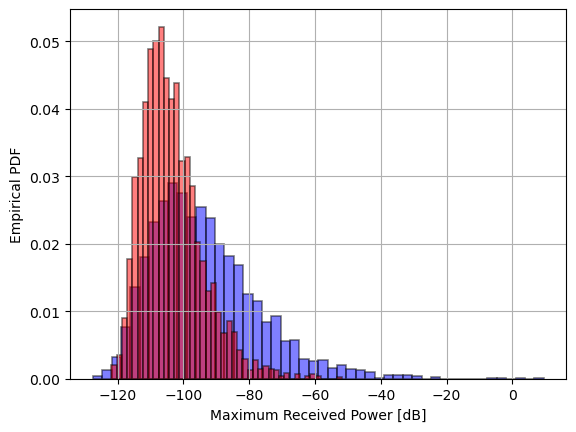

In [18]:
#Plot histograms of maximum and inter powers

fig = plt.figure()
plt.hist(10*np.log10(max_powers), bins='auto', alpha=0.5, color='blue', edgecolor='black', linewidth=1.2, density=True)
plt.hist(10*np.log10(inter_powers), bins='auto', alpha=0.5, color='red', edgecolor='black', linewidth=1.2, density=True)
#plt.xlim([0, 10e-6])
plt.xlabel('Maximum Received Power [dB]')
plt.ylabel('Empirical PDF')
plt.grid()
plt.show()

*All this is great but... what if we have obstacles in the way ? Let's see how the ICI is affected by the presence of obstacles. In the following simulation, we will use the same geometry as before but we will add circular buildings randomly located in the area. The following simulation shows the power received by the user in the presence of buildings.*

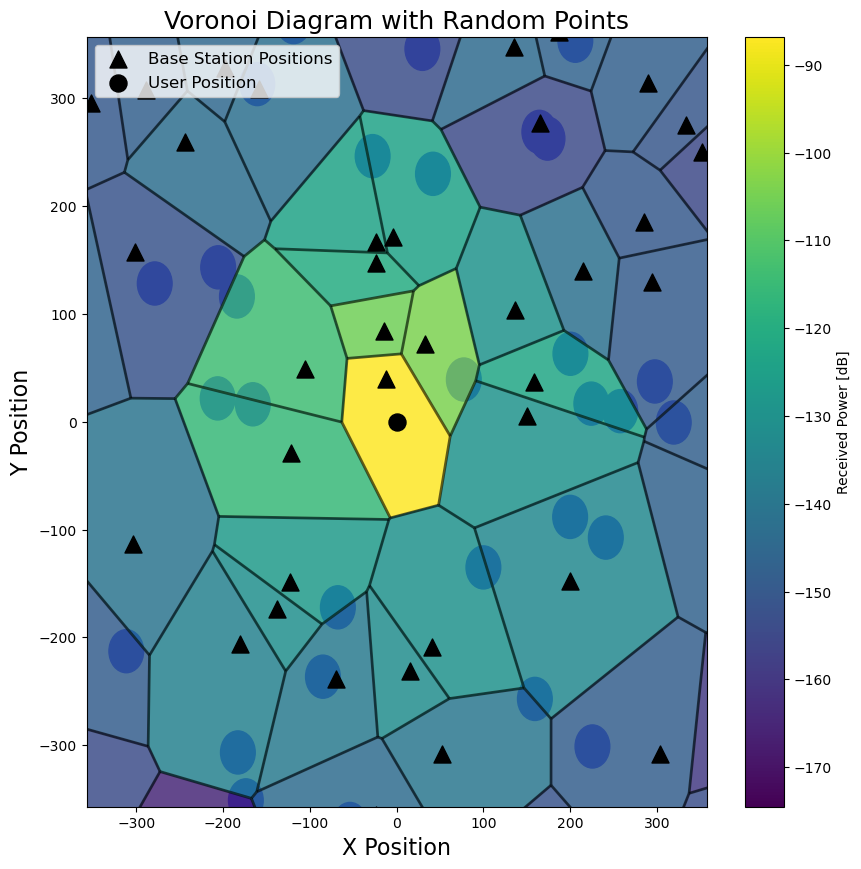

In [7]:
from obstacles import CircularObstacles
from utils import reflection_point_from_los, line_segment_circle_intersection_depth

# Fix random seed for the simulation
np.random.seed(18)

# Set parameters
dim = 500
npoints = 64
r=20

# Set user location
user_position = np.array([0, 0])

# Generate random points for the BS's
points = np.random.uniform(-dim, dim, (npoints, 2))

# Create figure to show results
fig, ax = plt.subplots(figsize=(10, 10))  

# Generate Obstacles 
obstacles = CircularObstacles.generate(npoints, radius=r)
obstacles.centers = obstacles.centers*dim*2
# Do not consider obstacles containing BS's
cond = obstacles.contains(points)
obstacles.centers =  obstacles.centers[~cond]
# Draw obstacles in circles
obstacles.draw(fill=True, color='blue', alpha=1)

# Create Voronoi diagram
vor = Voronoi(points)

# Plot Voronoi diagram with customizations
voronoi_plot_2d(vor, show_vertices=False, show_points=False, line_colors='k', line_width=2, line_alpha=0.6, ax=ax)

# Calculation of powers based on Ray Tracing
powers = received_power(points, alpha=6)
#Ray Tracing
center_obstacles = obstacles.centers
depths = np.zeros(len(points))
# Compute the depth of the intersection between the line of sight and the obstacles
for j in range(len(center_obstacles)) :
    for i in range(len(points)) : 
        # Depth Line of Sight
        depths[i] += line_segment_circle_intersection_depth(x0=points[i,0], y0=points[i,1], x1=0, y1=0, xc=center_obstacles[j,0], yc=center_obstacles[j,1], rc=r) 

# Compute the depth of the intersection between the line of sight and the obstacles
points_from_segments = reflection_point_from_los(x0=points[:,0], y0=points[:,1], z0=10, x1=0, y1=0, z1=2) #we consider the user to be at the center of the cell (0,0)
for j in range(len(center_obstacles)) :
    for i in range(len(points_from_segments)) : 
        #Between BS and reflection point
        depths[i] += line_segment_circle_intersection_depth(x0=points_from_segments[i,0], y0=points_from_segments[i,1], x1=0, y1=0, xc=center_obstacles[j,0], yc=center_obstacles[j,1], rc=r)
        #Between reflection point and smartphone
        depths[i] += line_segment_circle_intersection_depth(x0=points[i,0], y0=points[i,1], x1=points_from_segments[i,0], y1=points_from_segments[i,1], xc=center_obstacles[j,0], yc=center_obstacles[j,1], rc=r)

alpha_calc = 0.05 #0.05 #alpha used by default in received_power
powers_obstacles = powers*np.exp(-alpha_calc*depths)

# Normalization for cmap color
minima = min(10*np.log10(powers_obstacles))
maxima = max(10*np.log10(powers_obstacles))

# Normalize chosen colormap
norm = mpl.colors.Normalize(vmin=minima, vmax=maxima, clip=True)
mapper = cm.ScalarMappable(norm=norm, cmap=cm.viridis)

# Plot colors in function of the power received from the BS. 
for r in range(len(vor.point_region)):
    region_index = vor.point_region[r]
    region = vor.regions[region_index]
    if region_index != -1 and -1 not in region and len(region) > 2:
        polygon = [vor.vertices[i] for i in region]
        plt.fill(*zip(*polygon), color=mapper.to_rgba(10*np.log10(powers_obstacles[r])), alpha=0.85)

# Plot points
plt.scatter(points[:, 0], points[:, 1], c='black', marker='^',  label='Base Station Positions', s=150)
plt.scatter(user_position[0], user_position[1], c='black', marker='o', label='User Position', s=150)

# Set plot limits and labels
plt.xlim(-dim/1.4, dim/1.4)
plt.ylim(-dim/1.4, dim/1.4)
plt.xlabel('X Position', fontsize=16)
plt.ylabel('Y Position', fontsize=16)
plt.title('Voronoi Diagram with Random Points', fontsize=18)

# Add colorbar
sm = plt.cm.ScalarMappable(cmap=cm.viridis, norm=norm)
sm.set_array([])
plt.colorbar(sm, label='Received Power [dB]')

# Add legend
plt.legend(loc='upper left', fontsize=12)

# Show the plot
#plt.grid(True)
plt.show()


*As for the previous results, we can perform several simulations to gather information about the distribution of the ratio of powers, the distance between the user and the closest BS, the distance between the user and the second closest BS and the difference between those two distances.*

In [92]:
# Number of iterations to run
niters = 1000
# Arrays to store the results, for the obstacles and non-obstacles cases
ratio_power = np.zeros(niters)
ratio_power_obstacles = np.zeros(niters)
max_powers = np.zeros(niters)
max_powers_obstacles = np.zeros(niters)
inter_powers = np.zeros(niters)
inter_powers_obstacles = np.zeros(niters)

for k in range(niters) :
    
    # Set parameters
    dim = 500
    npoints = 64
    r=10

    # Set user location
    user_position = np.array([0, 0])

    # Generate random points
    points = np.random.uniform(-dim, dim, (npoints, 2))

    # Generate Obstacles 
    obstacles = CircularObstacles.generate(npoints*10, radius=r)
    obstacles.centers = obstacles.centers*dim*2

    # Create Voronoi diagram
    vor = Voronoi(points)

    # Calculation of powers based on Ray Tracing
    powers = received_power(points, alpha=6)
    #Ray Tracing
    center_obstacles = obstacles.centers
    depths = np.zeros(len(points))
    for j in range(len(center_obstacles)) :
        for i in range(len(points)) : 
            # Depth Line of Sight
            depths[i] += line_segment_circle_intersection_depth(x0=points[i,0], y0=points[i,1], x1=0, y1=0, xc=center_obstacles[j,0], yc=center_obstacles[j,1], rc=r) 

    points_from_segments = reflection_point_from_los(x0=points[:,0], y0=points[:,1], z0=10, x1=0, y1=0, z1=2) #we consider the user to be at the center of the cell (0,0)
    for j in range(len(center_obstacles)) :
        for i in range(len(points_from_segments)) : 
            #Between BS and reflection point
            depths[i] += line_segment_circle_intersection_depth(x0=points_from_segments[i,0], y0=points_from_segments[i,1], x1=0, y1=0, xc=center_obstacles[j,0], yc=center_obstacles[j,1], rc=r)
            #Between reflection point and smartphone
            depths[i] += line_segment_circle_intersection_depth(x0=points[i,0], y0=points[i,1], x1=points_from_segments[i,0], y1=points_from_segments[i,1], xc=center_obstacles[j,0], yc=center_obstacles[j,1], rc=r)

    alpha_calc = 1 #alpha used by default in received_power
    powers_obstacles = powers*np.exp(-alpha_calc*depths)
    
    # Store results in the array. 
    ratio_power[k] = np.max(powers)/(np.sum(powers) - np.max(powers))
    ratio_power_obstacles[k] = np.max(powers_obstacles)/(np.sum(powers_obstacles) - np.max(powers_obstacles))
    max_powers[k] = np.max(powers)
    max_powers_obstacles[k] = np.max(powers_obstacles)
    inter_powers[k] = np.sum(powers) - np.max(powers)
    inter_powers_obstacles[k] = np.sum(powers_obstacles) - np.max(powers_obstacles)


In [ ]:
# Save the results for later use ;-)

np.save("data/ratio_power_interf_obstacles.npy" , ratio_power)

*We can now compare the ratio of powers (between the useful  power and the interference power) in the presence of buildings and in the absence of buildings. We can observe that the presence of buildings increases the ratio of powers. This is due to the fact that the buildings attenuate the signal from the other BS than the one associated to the UE.*

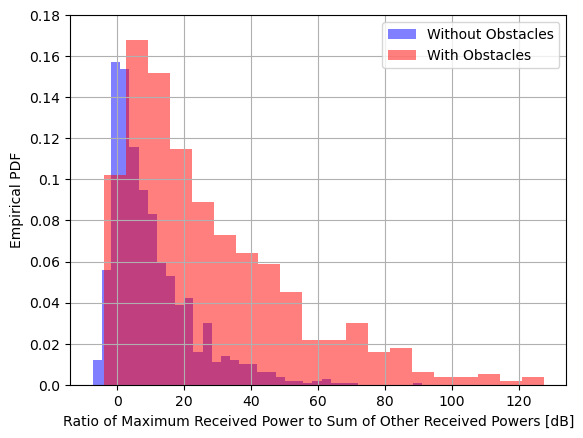

In [93]:
# Plot the histogram of the ratio of maximum power to sum of other powers
fig = plt.figure()
plt.grid()
plt.hist(10*np.log10(ratio_power), bins='auto', alpha=0.5, color='blue', density=False, label='Without Obstacles')
locs, _ = plt.yticks()
plt.yticks(locs,np.round(locs/len(ratio_power),3))
plt.hist(10*np.log10(ratio_power_obstacles), bins='auto', alpha=0.5, color='red', density=False, label='With Obstacles')
locs, _ = plt.yticks()
plt.yticks(locs,np.round(locs/len(ratio_power_obstacles),3))
#plt.xlim([0, 10])
plt.xlabel('Ratio of Maximum Received Power to Sum of Other Received Powers [dB]')
plt.ylabel('Empirical PDF')
plt.legend()
plt.show()